In [ ]:
# Install the code depenedencies
!pip install -r requirements.txt
# download the data
!curl https://zenodo.org/record/5535556/files/data.tar.gz -o data.tar.gz
# extract the data
!tar -xvzf data.tar.gz

# Atom Centered Symmetry Functions

ACSFs are a convenient way of transforming atomic coortinates and types into a computer-friendly string of numbers. Each atom gets its own set of ACSFs, computed using itself as the center, and all other atomic coordinates, which encode its chemical environment.<br>
<img src="./images/acsf-schema.png" width="400px"><br>
The two main type of ACSFs are two- an three-body. Each set of ACSFs becomes the input of a neural network that calculates the corresponding energy contribution. The only important quantity is the total energy of the system, given by the sum of all contributions.


For more info see: Jörg Behler, <i>J. Chem. Phys.</i> <b>134</b>, 074106 (2011)

# A pratical example

We are going to see ACSFs in action for a simple dimer system.

Since there is only one atomic species and only two atoms, we will not need the three-body terms. Due to the symmetry of the system we can just compute the ACSFs for one of the two atoms, feed them to a single NN to get the total energy directly.

Here are some definitions we will need.

In [11]:
# --- INITIAL DEFINITIONS ---
from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ase import Atoms
from visualise import view

# cutoff for all ACSF
Rcut = 5.0

# cutoff function
def fcut(r):
    if r >= Rcut: return 0
    return (math.cos(math.pi * r/Rcut)+1) * 0.5

# G1 function definition
def G1f(r, eta, Rs):
     return math.exp(-eta*(r-Rs)*(r-Rs)) * fcut(r)

### Creating the training set

In order to learn the relationship between ACSFs and the energy of the system, we need a database of ACSFs for several atomic configurations, and the corresponding energy.

The sample configurations consist of the dimer, stretched and compressed. In reality the energy is calculated with quantum methods (DFT, CC, ...) but here we will use a simple Lennard-Jones function.

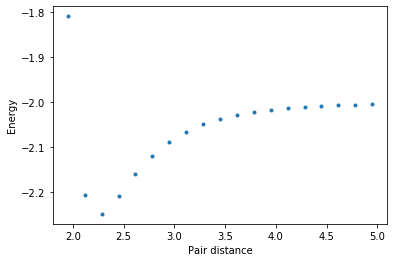

In [12]:
# array of meaningful distances
dists = numpy.arange(1.95, Rcut, Rcut/30)
# LJ energy at those distances
energy = numpy.power(dists/2,-12)-numpy.power(dists/2,-6) - 2

plt.plot(dists, energy,'.' )
plt.xlabel('Pair distance')
plt.ylabel('Energy')
plt.show()

Then we calculate the ACSFs for each dimer configuration. The results are formatted as a matrix: one row for each configuration, one column for each ACSF.

Number of configurations: 19
Number of ACSfs: 3


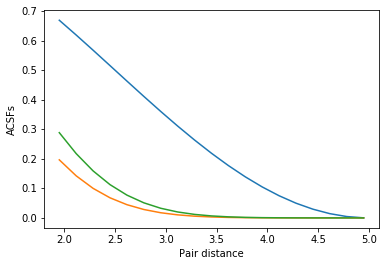

In [13]:
# ACSFs G1 parameter pairs: this is a list of eta/Rs values
params = [(0.4, 0.2),(0.4, 0.5)]

# initialise a matrix that will store the ACSFs of the first atom in all dimer configurations
nConfs = dists.shape[0]
acsf = numpy.zeros((nConfs, 1+len(params)))

print("Number of configurations: " + str(nConfs))
print("Number of ACSfs: " + str(acsf.shape[1]))


for k in range(nConfs): # for each configuration
    
    r = dists[k] # distance between atoms
    # compute G0 - sum of cutoffs
    acsf[k,0] = fcut(r)
    
    # compute all the G1
    for p in range(len(params)):
        # extract parameters
        eta,rs = params[p]
        # compute G1
        acsf[k,1+p] = G1f(r, eta, rs)

# plot the Gs as a function of distance
for a in range(acsf.shape[1]):
    plt.plot(dists, acsf[:,a])
plt.xlabel('Pair distance')
plt.ylabel('ACSFs')
plt.show()

#### OPTIONAL TRICK

We can center the ACSFs around their mean and rescale them so that their standard deviation is 1. This is a common trick in ML with neural networks, to make the learning easier.

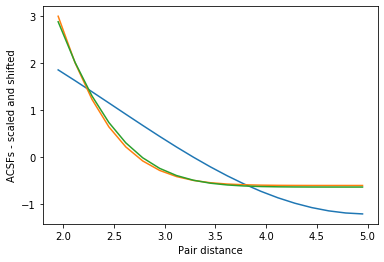

In [14]:
acsf_mean = numpy.mean(acsf, axis=0)
for a in range(acsf.shape[1]):
    acsf[:,a] -= acsf_mean[a]
acsf_std = numpy.std(acsf, axis=0)
for a in range(acsf.shape[1]):
    acsf[:,a] /= acsf_std[a]

# plot the Gs as a function of distance
for a in range(acsf.shape[1]):
    plt.plot(dists, acsf[:,a])
plt.xlabel('Pair distance')
plt.ylabel('ACSFs - scaled and shifted')
plt.show()

### Training

We create a neural network and train it on the ACSF database we just constructed.

In [15]:
# setup the neural network
# the network uses tanh function on all hidden neurons

nn = MLPRegressor(hidden_layer_sizes=(5,), activation='tanh')

The fitting may not be trivial since our database is small... the next instruction can be executed multiple times let the NN train more and hopefully improve.

In [16]:
# change some training parameters
nn.set_params(solver='lbfgs', alpha=0.001, tol=1.0e-10, learning_rate='constant', learning_rate_init=0.01)
# do some training steps
nn.fit(acsf, energy);

Mean Abs Error (training)  :  0.0025175641260709765


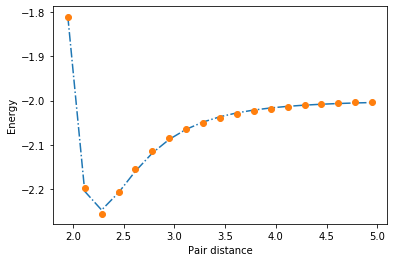

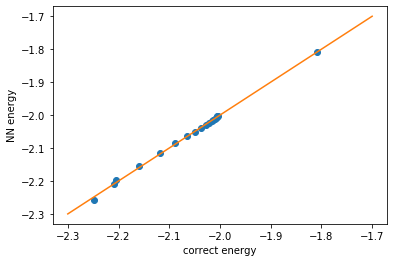

In [17]:
# evaluate the training error
energyML = nn.predict(acsf)

print ("Mean Abs Error (training)  : ", (numpy.abs(energyML-energy)).mean())

# energy curve
plt.plot(dists, energy,'-.' )
plt.plot(dists, energyML,'o' )
plt.xlabel('Pair distance')
plt.ylabel('Energy')
plt.show()

# regression plot
plt.plot(energy,energyML,'o')
plt.plot([-2.3,-1.7],[-2.3,-1.7]) # perfect fit line
plt.xlabel('correct energy')
plt.ylabel('NN energy')
plt.show()

### Remarks

Do not be fooled! Real systems are much more difficult to model, requiring more ACSFs, larger NNs, and much larger datasets for training.

## Exercises

### 1. Create a vaidation set and test the NN performance

For simplicity we just checked the error on training data, but it is better to check performance on a validation set not included in the training.

Create different dimer configurations and test NN performance on those.

### 2. Craft you own energy

Make the dimer energy expression more complex and attempt to machine-learn it.

### 3. Add/edit the ACSFs parameters

Try to change the ACSFs parameters to get better model performance.

### 4. A real molecule

Here is a real organic molecule... try to compute the ACSFs for its atoms using the DScribe package.
Documentation can be found here: https://singroup.github.io/dscribe/tutorials/acsf.html

In [18]:
# atomic positions as matrix
molxyz = numpy.load("./data/molecule.coords.npy")
# atom types
moltyp = numpy.load("./data/molecule.types.npy")

atoms_sys = Atoms(positions=molxyz, numbers=moltyp)
view(atoms_sys)


In [19]:
from dscribe.descriptors import ACSF

# Setting up the ACSF descriptor
acsf = ACSF(
    species=["H", "C", "N", "O"],
    rcut=6.0,
    # configure parameters for desired ACSFs
    g2_params=[[1, 1], [1, 2], [1, 3]],
    g4_params=[[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]],
)

In [ ]:
# calculate the descriptor